# 순환신경망 (Recurrent Neural Networks) Regression

##### jupyter notebook 단축키

- ctrl+enter: 셀 실행   
- shift+enter: 셀 실행 및 다음 셀 이동   
- alt+enter: 셀 실행, 다음 셀 이동, 새로운 셀 생성
- a: 상단에 새로운 셀 만들기
- b: 하단에 새로운 셀 만들기
- dd: 셀 삭제(x: 셀 삭제)

## **0. 모듈 불러오기**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

import time
import copy

import random
import matplotlib.pyplot as plt     

# regression 평가지표
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return mape

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore') 

## **1. 데이터 불러오기**
- https://hoya012.github.io/blog/reproducible_pytorch/

In [ ]:
random_seed = 2023
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

- https://cseweb.ucsd.edu/~yaq007/NASDAQ100_stock_data.html
- 나스닥 100에 속한 81개 기업의 주가와 나스닥 100지수 값으로 구성
- 2016년 7월 26일부터 2016년 12월 22일까지 수집 (105일)
- 누락된 데이터에 대해 정제된 데이터
- X: 81개 종목의 종가
- y: NASDAQ 100 지수

In [ ]:
data = pd.read_csv('./data/reg_nasdaq100.csv')

### **1.1 Data Exploratory Data Analysis**

In [ ]:
data.head() # 상위 5개

In [ ]:
data.tail() # 하위 5개

In [ ]:
data[:10]

In [ ]:
data.shape # 데이터 차원 확인

In [ ]:
data.describe() # 데이터 통계값 확인

## **2. 모델링을 위한 데이터 전처리**
### **2.1 Train/Test 데이터 나누기**
- 학습 데이터와 테스트 데이터를 70%, 30% 비율로 나누기

In [ ]:
x = data.drop(['NDX'], axis=1)
y = data[['NDX']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('x_train examples')
x_train.head()

### **2.2 MinMax Scaling**

In [ ]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

columns_list = list(x_train.columns)
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_test)

y_train = y_scaler.fit_transform(y_train)
y_test = y_scaler.transform(y_test)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print('x_train examples')
pd.DataFrame(x_train, columns = columns_list).head()

### **2.2 Data Windowing**

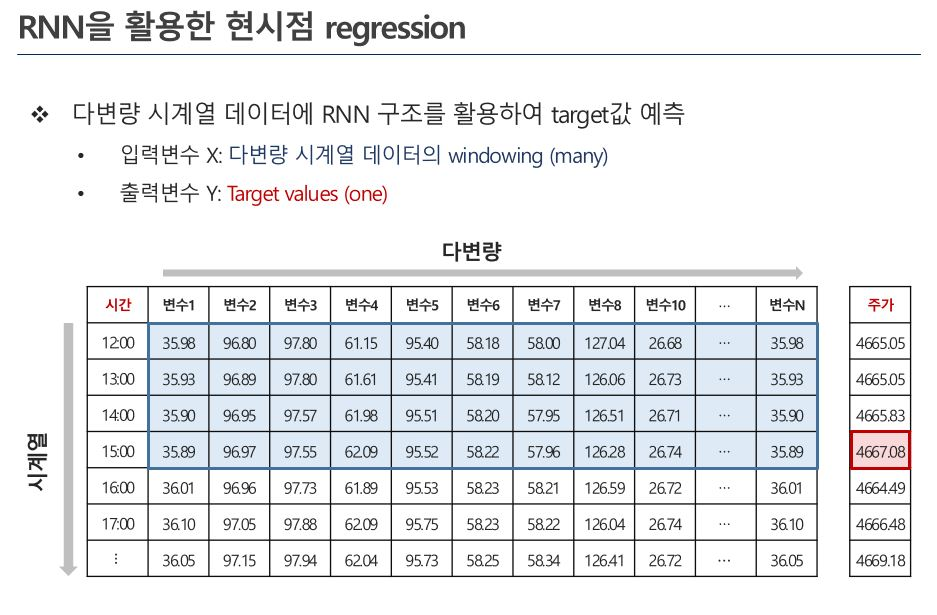

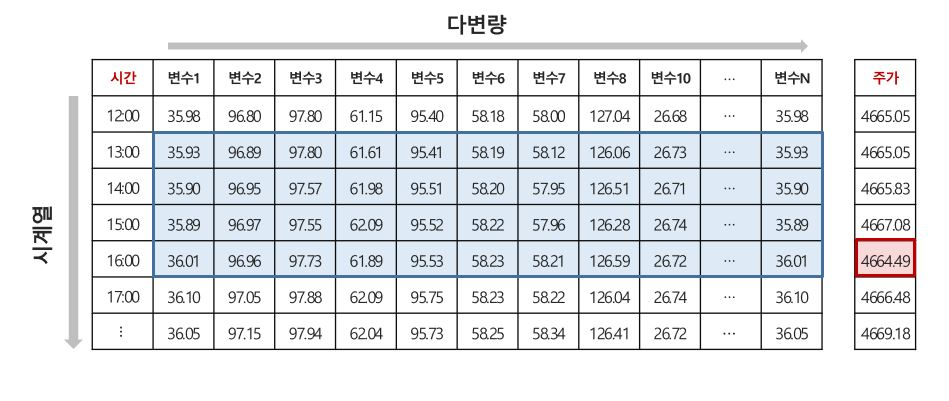

In [ ]:
def windowing_process(x, y, window_size, shift_size, last = True):
    try:
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
    except:
        pass
    
    x_window = []
    y_window = []
    
    for start_idx in range(0, x.shape[0] - window_size + 1, shift_size):
        x_window.append(x[start_idx:start_idx + window_size])
        
        if last == True:
            y_window.append(y[start_idx + window_size - 1])  # 마지막 index의 값을 사용하는 경우
        
        else:
            y_window.append(np.mean(y[start_idx:start_idx + window_size]))  # window 내 값들의 평균
    
    x_window = np.array(x_window)
    y_window = np.array(y_window)
    
    return x_window, y_window

In [ ]:
print('-'*35)
print('Windowing processing 전')
print('-'*35)
print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('\n')

x_train, y_train = windowing_process(x_train, y_train, 5, 1, True)
x_test, y_test = windowing_process(x_test, y_test, 5, 1, True)

print('-'*35)
print('Windowing processing 후')
print('-'*35)
print(f'x_train shape is {x_train.shape}')
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')
print('-'*35)
print('\n')

In [ ]:
n_train = int(0.8 * len(x_train))
x_valid, y_valid = x_train[n_train:], y_train[n_train:]
x_train, y_train = x_train[:n_train], y_train[:n_train]

print(f'x_train shape is {x_train.shape}') # (batch_size x seq_len x input_size)
print(f'y_train shape is {y_train.shape}')
print('-'*35)
print(f'x_train shape is {x_valid.shape}')
print(f'y_train shape is {y_valid.shape}')
print('-'*35)
print(f'x_test shape is {x_test.shape}')
print(f'y_test shape is {y_test.shape}')

## **3. 순환신경망 (RNN) 모델링**
### **3.1 Define the Model Structure**
- https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

In [ ]:
class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional, device='cuda'):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional == True else 1
        self.device = device
        
        # recurrent layer 설정
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
     
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, 1)  # self.num_classes = 1로 설정된 구조
        # self.fc = nn.Linear(self.num_directions * hidden_size, self.num_classes) --> classification
        
    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        # x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(self.device)
        
        # RNN으로부터 output 도출
        out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        out = self.fc(out[:, -1, :])
        return out

### **3.2 Define The Training Testing Strategy**

In [ ]:
class Train_Test():
    def __init__(self,  train_loader, valid_loader, test_loader, input_size, device='cuda'): 
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.test_loader = test_loader

        self.input_size = input_size

    def train(self, model, dataloaders, criterion, num_epochs, optimizer):
        since = time.time() 
        
        train_loss_history = []
        val_loss_history = []

        best_model_wts = copy.deepcopy(model.state_dict()) # 모델의 초기 Weight값 (각 Layer 별 초기 Weight값이 저장되어 있음)
        best_loss = 999999999 # MSE는 작을수록 좋은 metric이므로, 초기 높은 값에서 갱신

        for epoch in range(num_epochs):
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print()
                print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            # 각 epoch마다 순서대로 training과 validation을 진행
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # 모델을 training mode로 설정
                else:
                    model.eval()   # 모델을 validation mode로 설정

                running_loss = 0.0
                running_total = 0

                # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
                for inputs, targets in dataloaders[phase]:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    # seq_lens = seq_lens.to(self.parameter['device'])
                    
                    # parameter gradients를 0으로 설정
                    optimizer.zero_grad()

                    # forward
                    # training 단계에서만 gradient 업데이트 수행
                    with torch.set_grad_enabled(phase == 'train'):

                        # input을 model에 넣어 output을 도출한 후, loss를 계산함
                        outputs = model(inputs)
                        outputs = outputs.reshape(-1)
                        
                        loss = criterion(outputs, targets)

                        # backward (optimize): training 단계에서만 수행
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # batch별 loss를 축적함
                    running_loss += loss.item() * inputs.size(0)
                    running_total += targets.size(0)

                # epoch의 loss 및 accuracy 도출
                epoch_loss = running_loss / running_total
                                    
                if epoch == 0 or (epoch + 1) % 10 == 0:
                    print('{} Loss: {:.4f}'.format(phase, epoch_loss))

                # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                elif phase == 'val':
                    val_loss_history.append(epoch_loss)

        # 전체 학습 시간 계산 (학습이 완료된 후)
        time_elapsed = time.time() - since
        print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val MSE: {:4f}'.format(best_loss))

        # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
        model.load_state_dict(best_model_wts)
        return model, train_loss_history, val_loss_history

    def test(self, model, test_loader):
        model.eval()   # 모델을 validation mode로 설정
        
        # test_loader에 대하여 검증 진행 (gradient update 방지)
        with torch.no_grad():

            preds = []
            y_true = []
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # forward
                # input을 model에 넣어 output을 도출
                pred = model(inputs)
                
                preds.extend(pred.detach().cpu().numpy())
                y_true.extend(targets.detach().cpu().numpy())

            preds = torch.tensor(preds).reshape(-1)
            y_true = torch.tensor(y_true)
            
            mse = nn.MSELoss()(preds, y_true).item()
            preds = preds.detach().cpu().numpy()
        return preds, mse

## **4. 순환신경망(RNN) 모델 학습**

### **4.1 순환신경망 (RNN) 하이퍼파라미터 설명**

- batch_size: 학습 및 검증에 사용할 배치의 크기
- input_size: 변수 개수
- hidden_size: 모델의 hidden dimension
- num_layers: 모델의 layer 개수
- bidirectional: 모델의 양방향성 여부
- num_epochs: 학습할 epoch 횟수
- device: 사용할 자원 선정
- best_model_path: 모델 파라미터 저장 위치

In [ ]:
batch_size = 128
input_size = x_train.shape[2]
hidden_size = 64
num_layers = 2
bidirectional = True
num_epochs = 200
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu') 
best_model_path = './ckpt/rnn_reg.pt'

### **4.2 Construct Data Loaders and Model**

In [ ]:
datasets = []
for dataset in [(x_train, y_train), (x_valid, y_valid), (x_test, y_test)]:
    x_data = dataset[0]
    y_data = dataset[1]
    datasets.append(torch.utils.data.TensorDataset(torch.Tensor(x_data), torch.Tensor(y_data)))

trainset, validset, testset = datasets[0], datasets[1], datasets[2]
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [ ]:
model = RNN_model(input_size, hidden_size, num_layers, bidirectional, device)
model = model.to(device)

### **4.3 Model Training and Save Weights(Parameters)**

In [ ]:
dataloaders_dict = {'train': train_loader, 'val': valid_loader}

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
trainer = Train_Test(train_loader, valid_loader, test_loader, input_size, device)
best_model, train_loss_history, val_loss_history = trainer.train(model, dataloaders_dict, criterion, num_epochs, optimizer)

In [ ]:
torch.save(best_model.state_dict(), best_model_path)

## **5. Model Validation**

### **5.1 Loss History Visualization**

In [ ]:
plt.figure(figsize=(8,5))
plt.title('Loss History')
plt.plot(range(num_epochs), train_loss_history, c='blue', label='Train Loss')
plt.plot(range(num_epochs), val_loss_history, c='red', label='Validation Loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

### **5.2 Load Model Weights(Parameters)**

In [ ]:
model.load_state_dict(torch.load(best_model_path))

In [ ]:
y_pred, mse = trainer.test(model, test_loader)
y_pred_inverse = y_scaler.inverse_transform(pd.DataFrame(y_pred))
y_test_inverse = y_scaler.inverse_transform(pd.DataFrame(y_test))
y_train_inverse = y_scaler.inverse_transform(pd.DataFrame(y_train))
y_valid_inverse = y_scaler.inverse_transform(pd.DataFrame(y_valid))

print('y prediction (raw)')
print(y_pred)
print('-'*35)
print('y prediction (inverse minmax scaler)')
print(y_pred_inverse)

### **5.3 모델 평가**

#####  R squared (결정계수 $({r})^{2}$) <br>
- $\frac{SSR}{SST} = 1- \frac{SSR}{SST}%$

##### Mean Absolute Error (평균 절대 오차) <br>
- $\frac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$

##### Mean Squared Error (평균 제곱 오차) <br>
- $\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$   

#####  Root Mean Squared Error (제곱근 평균 제곱 오차) <br>
- $\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$

##### Mean Absolute Percentage Error (평균 절대비 오차) <br>
- $\sum_{i=1}^{n} |\frac{y_{i} - \hat{y}_{i}}{\hat{y}_{i}}| *100\%$

In [ ]:
def regression_report(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred) 
    mse = mean_squared_error(y_true, y_pred) 
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
      
    print('The regression reports are as follows:')
    print('r2: ', round(r2,4))
    print('MAE: ', round(mae,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(rmse,4))
    print('MAPE: ', round(mape,4))
    return r2, mae, mse, rmse, mape

r2, mae, mse, rmse, mape = regression_report (y_test_inverse.flatten(), y_pred_inverse.flatten())

In [ ]:
y_train_concat = np.concatenate([y_train_inverse, y_valid_inverse], axis=0)
y_train = np.concatenate([y_train_concat, np.array([np.nan]*len(y_test_inverse)).reshape(len(y_test_inverse), -1)], axis=0)
y_test = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_test_inverse], axis=0)
y_pred = np.concatenate([np.array([np.nan]*len(y_train_concat)).reshape(len(y_train_concat), -1), y_pred_inverse], axis=0)

y_train = pd.DataFrame(y_train, columns = ['Train set'])
y_test = pd.DataFrame(y_test, columns = ['Test set'])
y_pred = pd.DataFrame(y_pred, columns = ['Predictions'])

In [ ]:
plt.figure(figsize=(16,6))
plt.title('RNN regression results', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('NASDAQ 100 Index', fontsize=12)
plt.axvline(x=len(y_train_concat), color='r', label='Start Prediction', ls='--')
plt.plot(y_train['Train set'])
plt.plot(y_test['Test set'])
plt.plot(y_pred['Predictions'])
plt.legend(['Start Prediction', 'Train set', 'Test set', 'Predictions'], loc='lower right')
plt.show()

# EOD